In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score

from train_model_weighted_loss import train_model
from validate import validate

seed = 42
torch.manual_seed(1337)
BATCH_SIZE = 5 #5
N_EPOCHS = 100 #100
LEARNING_RATE = 0.001 #0.001
DROPOUT_RATE = 0.4 #0.4
NUM_CLASSES = 2 #2
FILETYPE = '/nourest.nii'
EXTRA_DATA = True

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class COBRE_dataset_subj(Dataset):
    """This Dataset class loads pairs of COBRE images and labels into the computer memory. The entire subject file is loaded.

    Parameters:
    - data_path (str): Path to the folder containing images and labels
    Returns:
    - Tensor: Torch tensor with COBRE time-series
    - int: label (0 or 1)

   """
    def __init__(self, data_path):
        self.data_path = data_path
        self.num_subjects = len(os.listdir(self.data_path))

    def __len__(self):
        return self.num_subjects

    def __getitem__(self, index):
        subject = os.listdir(self.data_path)[index]
        img = self.data_path + '/' + subject + FILETYPE
        label = self.data_path + '/' + subject + '/' + subject + '_data.csv'

        img = nib.load(img).get_fdata()
        img = np.swapaxes(img, 0, 3)
        img = img[10::]
        img = torch.from_numpy(img)
        img = img.to(torch.float)

        label = pd.read_csv(label)
        label = label.iloc[0]['subject_type']
        # covariates = df.iloc[0]['age', 'gender', 'handedness'].tolist()

        ### LABEL
        if label == 'Patient':
            label = 1
        elif label == 'Control':
            label = 0
        else:
            print('Something wrong with data label:', end=' ')
            print(label)
        
        ### AGE, GENDER AND HANDEDNESS
        # age = df.iloc[0]['age']
        # gender = df.iloc[0]['gender']
        # handedness = df.iloc[0]['handedness']

        # ### AGE
        # # age = (age - 18)/(65-18)

        # ### GENDER
        # if gender == 'Female':
        #     gender = 1
        # elif gender == 'Male':
        #     gender = 0
        # else:
        #     print('Something wrong with data label (gender):', end=' ')
        #     print(gender)

        # ### HANDEDNESS
        # if handedness == 'Right':
        #     handedness = [1,0]
        # elif handedness == 'Left':
        #     handedness = [0,1]
        # elif handedness == 'Both':
        #     handedness = [1,1]
        # else:
        #     print('Something wrong with data label (handedness):', end=' ')
        #     print(handedness)

        # covariates = [age, gender]
        # for h in handedness:
        #     covariates.append(h)
        
        # covariates = torch.Tensor(covariates)

        return img, label #, covariates

In [3]:
train_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/train'
val_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/val'
extra_train_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/removed/train'
extra_val_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/removed/val'

train_data = COBRE_dataset_subj(train_path)
val_data = COBRE_dataset_subj(val_path)
extra_train_data = COBRE_dataset_subj(extra_train_path)
extra_val_data = COBRE_dataset_subj(extra_val_path)

if EXTRA_DATA:
    train_data = ConcatDataset([train_data, extra_train_data])
    val_data = ConcatDataset([val_data, extra_val_data])

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True) #, pin_memory=True, pin_memory_device=device)
valloader = DataLoader(val_data, batch_size=1, shuffle=False) #, pin_memory=True, pin_memory_device=device)

In [4]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv3d(150, 300, 5) #, padding=5)
#         self.pool = nn.MaxPool3d(2, 2)
#         self.conv2 = nn.Conv3d(300, 16, 5)
#         #self.fc1 = nn.LazyLinear(120)
#         self.fc1 = nn.Linear(16 * 2 * 2, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 17)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()
# net = net.to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
# ## Alternativ fra ChatGPT

# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = nn.Conv3d(in_channels=150, out_channels=50, kernel_size=(3, 3, 3), padding=1)
#         self.conv2 = nn.Conv3d(in_channels=50, out_channels=100, kernel_size=(3, 3, 3), padding=1)
#         self.conv3 = nn.Conv3d(in_channels=100, out_channels=150, kernel_size=(3, 3, 3), padding=1)
        
#         # Max pooling layer
#         self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(150 * 891, 512)  # Adjust the input size based on your spatial dimensions, 9 * 11 * 9
#         self.fc2 = nn.Linear(512, num_classes)
        
#         # Dropout layer to reduce overfitting
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
        
#         # Flatten the tensor before fully connected layers
#         x = x.view(-1, 150 * 891)  # Adjust the size based on your spatial dimensions
        
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         return x

# # Instantiate the model
# num_classes = 2  # Adjust based on the number of classes in your classification task
# net = SimpleCNN(num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [6]:
# ### med UNET som inspirasjon

# class UNET_inspired(nn.Module):
#     def __init__(self, num_classes, in_channels):
#         super(UNET_inspired, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = (Conv_layer(in_channels, in_channels*2))
#         self.down1 = (Down(in_channels*2, in_channels*4))
#         self.down2 = (Down(in_channels*4, in_channels*8))
#         self.down3 = (Down(in_channels*8, in_channels*16))
#         self.pool = (nn.MaxPool3d(kernel_size=(2,2,2), stride=2))
#         self.fc1 = (nn.LazyLinear(num_classes))
        
#         # Dropout layer to reduce overfitting
#         self.dropout = nn.Dropout(0.5)

        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.down1(x)
#         x = self.down2(x)
#         x = self.down3(x)
#         x = self.pool(x)
#         x = x.view(-1, 2400 * 80)
#         x = self.fc1(x)
#         return x


# class Conv_layer(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.conv(x)
        
# class Down(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.pool_conv = nn.Sequential(
#             nn.MaxPool3d(kernel_size=(2, 2, 2)),
#             Conv_layer(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.pool_conv(x)


# # Instantiate the model
# num_classes = 2  # Adjust based on the number of classes in your classification task
# unet = UNET_inspired(num_classes, 150)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(unet.parameters(), lr=0.001) #endre på denne for å få ned loss?

In [7]:
# ### SAVED, 77.777777
# ### med UNET som inspirasjon, med Mari sin hjelp
# ### kan ta inspirasjon fra denne: https://doi.org/gjj4xv

# class UNET_Mari(nn.Module):
#     def __init__(self, num_classes, in_channels):
#         super(UNET_Mari, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = (nn.Conv3d(in_channels, 10, kernel_size=(3, 3, 3), padding=1))
#         self.conv1_2 = (nn.Conv3d(10, 1, kernel_size=(3, 3, 3), padding=1))
#         self.pool1 = (nn.MaxPool3d(kernel_size=(2,2,2), stride=2))
#         self.dropout = (nn.Dropout(0.5))
#         self.conv2 = (nn.Conv2d(47, 1, kernel_size=(3, 3), padding=1))
#         # also more layers here, perhaps
#         self.pool2 = (nn.MaxPool2d(kernel_size=(2,2), stride=2))
#         self.fc1 = (nn.Linear(19*19, 4*4)) # one functional layer or two?
#         self.fc2 = (nn.Linear(4*4, num_classes))

#     def forward(self, x): # should ReLU be used in every step here?
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv1_2(x))
#         x = self.dropout(x)
#         x = self.pool1(x)
#         x = torch.squeeze(x, dim=1)
#         x = F.relu(self.conv2(x))
#         x = self.dropout(x)
#         x = self.pool2(x)
#         x = torch.flatten(x, start_dim=1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Instantiate the model
# num_classes = 2  # Adjust based on the number of classes in your classification task
# unet = UNET_Mari(num_classes, 150)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(unet.parameters(), lr=0.0001) #endre på lr for å få ned loss?

In [8]:
### 77.7777 modified med N_EPOCHS = 10?
### med UNET som inspirasjon, med Mari sin hjelp
### kan ta inspirasjon fra denne: https://doi.org/gjj4xv

class UNET_Mari(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(UNET_Mari, self).__init__()
        
        # Convolutional layers
        self.conv1 = (nn.Conv3d(140, 10, kernel_size=(3, 3, 3), padding=1))
        self.conv1_2 = (nn.Conv3d(10, 1, kernel_size=(3, 3, 3), padding=1))
        self.pool1 = (nn.MaxPool3d(kernel_size=(2,2,2), stride=2))
        self.dropout = (nn.Dropout(dropout_rate))
        self.conv2 = (nn.Conv2d(47, 1, kernel_size=(3, 3), padding=1))
        # also more layers here, perhaps
        self.pool2 = (nn.MaxPool2d(kernel_size=(2,2), stride=2))
        self.fc1 = (nn.Linear(19*19, 4*4)) # one functional layer or two?
        self.fc2 = (nn.Linear(4*4, num_classes))

    def forward(self, x): # should ReLU be used in every step here?
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_2(x))
        x = self.dropout(x)
        x = self.pool1(x)
        x = torch.squeeze(x, dim=1)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
unet = UNET_Mari(NUM_CLASSES, dropout_rate=DROPOUT_RATE)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(unet.parameters(), lr=0.00001) #endre på lr for å få ned loss?

In [9]:
best_params, losses_val, losses_train, accuracies_val, accuracies_train = train_model(unet, device, trainloader, valloader, N_EPOCHS, learning_rate=LEARNING_RATE, filetype=FILETYPE)

13:59:46.756388  |  Epoch 1/100  |  Train loss 2.680306574 |  Val loss 0.713093638 |  Train acc 0.524 | Validation accuracy 0.450
New best acc: 0.45  ------  Old acc: 0
14:01:10.394124  |  Epoch 2/100  |  Train loss 0.683674977 |  Val loss 0.708740136 |  Train acc 0.515 | Validation accuracy 0.450
Saving more overfit model with val acc: 0.45 and train acc: 0.5145631067961165
14:02:34.230582  |  Epoch 3/100  |  Train loss 0.686596623 |  Val loss 0.707509646 |  Train acc 0.534 | Validation accuracy 0.400
14:04:00.253040  |  Epoch 4/100  |  Train loss 0.679868451 |  Val loss 0.714396507 |  Train acc 0.563 | Validation accuracy 0.250
14:05:28.614456  |  Epoch 5/100  |  Train loss 0.653473147 |  Val loss 0.710825112 |  Train acc 0.602 | Validation accuracy 0.400
14:06:55.241305  |  Epoch 6/100  |  Train loss 0.643412160 |  Val loss 0.711809763 |  Train acc 0.592 | Validation accuracy 0.400
14:08:20.147760  |  Epoch 7/100  |  Train loss 0.610098057 |  Val loss 0.740087321 |  Train acc 0.612 

In [10]:
best_model = UNET_Mari(NUM_CLASSES, dropout_rate=DROPOUT_RATE)
best_model.load_state_dict(best_params)

# best_model = torch.load('models/best_model_nou_078947.pt')

best_model.to(device)

UNET_Mari(
  (conv1): Conv3d(140, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1_2): Conv3d(10, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(47, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=361, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [11]:
y_true, y_pred = validate(best_model, device, valloader, 'val')

Accuracy of the network on the val images: 0.800


In [12]:
y_true_train, y_pred_train = validate(best_model, device, trainloader, 'train')

Accuracy of the network on the train images: 1.000


In [13]:
print('Val')
print('F1-score:', f1_score(y_true, y_pred, average="weighted"))
print('Balanced accuracy score:', balanced_accuracy_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('ROC AUC score:', roc_auc_score(y_true, y_pred))
print()
print('Train')
print('F1-score:', f1_score(y_true_train, y_pred_train, average="weighted"))
print('Balanced accuracy score:', balanced_accuracy_score(y_true_train, y_pred_train))
print('Recall:', recall_score(y_true_train, y_pred_train))
print('Precision:', precision_score(y_true_train, y_pred_train))
print('ROC AUC score:', roc_auc_score(y_true_train, y_pred_train))

Val
F1-score: 0.7958333333333333
Balanced accuracy score: 0.7878787878787878
Recall: 0.9090909090909091
Precision: 0.7692307692307693
ROC AUC score: 0.787878787878788

Train
F1-score: 1.0
Balanced accuracy score: 1.0
Recall: 1.0
Precision: 1.0
ROC AUC score: 1.0


In [14]:
print('Val')
print('True:', y_true)
unique, count = np.unique(y_true, return_counts=True)
print(unique, count)
print('Pred:', y_pred)
unique, count = np.unique(y_pred, return_counts=True)
print(unique, count)
unique, count = np.unique([t==y for t,y in zip(y_true, y_pred)], return_counts=True)
print(unique, count)
print('Number of wrong predictions:', count[0])
print()
print('Train')
print('True:', y_true_train)
unique, count = np.unique(y_true_train, return_counts=True)
print(unique, count)
print('Pred:', y_pred_train)
unique, count = np.unique(y_pred_train, return_counts=True)
print(unique, count)
unique, count = np.unique([t==y for t,y in zip(y_true_train, y_pred_train)], return_counts=True)
print(unique, count)
print('Number of wrong predictions:', count[0])

Val
True: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
[0 1] [ 9 11]
Pred: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
[0 1] [ 7 13]
[False  True] [ 4 16]
Number of wrong predictions: 4

Train
True: [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[0 1] [52 51]
Pred: [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[0 1] [52 51]
[ True] [103]
Number of wrong predictions: 103


In [15]:
map = [t==p for t,p in zip(y_true, y_pred)]
data_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/val'

for i in range(len(valloader)):
    if(not map[i]):
        subject = os.listdir(data_path)[i]
        label = data_path + '/' + subject + '/' + subject + '_data.csv'
        label = pd.read_csv(label)
        label = label.iloc[0]
        print(label)
        print()

subject           40110
age                  43
gender             Male
handedness         Left
subject_type    Patient
diagnosis         295.7
Name: 0, dtype: object

subject           40120
age                  26
gender             Male
handedness        Right
subject_type    Control
diagnosis           NaN
Name: 0, dtype: object

subject           40128
age                  22
gender             Male
handedness        Right
subject_type    Control
diagnosis           NaN
Name: 0, dtype: object

subject           40130
age                  47
gender           Female
handedness        Right
subject_type    Control
diagnosis           NaN
Name: 0, dtype: object



In [16]:
map = [t==p for t,p in zip(y_true_train, y_pred_train)]
data_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/train'

for i in range(len(trainloader)):
    if(not map[i]):
        subject = os.listdir(data_path)[i]
        label = data_path + '/' + subject + '/' + subject + '_data.csv'
        label = pd.read_csv(label)
        label = label.iloc[0]
        print(label)
        print()

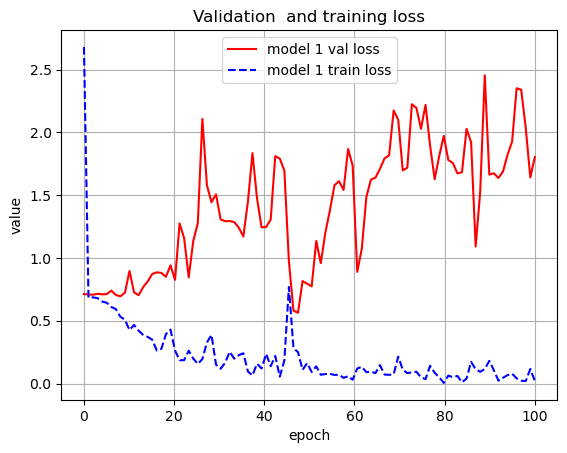

In [17]:
validation_losses = torch.Tensor([losses_val], device='cpu')
train_losses = torch.Tensor([losses_train], device='cpu')
colors = ['r', 'b', 'g']

for i in range(len(validation_losses)):
    xvalues = np.linspace(0, N_EPOCHS, len(validation_losses[i]))
    yvalues01 = validation_losses[i]
    yvalues02 = train_losses[i]
    name = "model %i "%(i+1)

    plt.plot(xvalues, yvalues01, label=name + "val loss", color='r')
    plt.plot(xvalues, yvalues02, label=name + "train loss", color='b', linestyle="dashed")

plt.title('Validation  and training loss')
plt.xlabel('epoch')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()

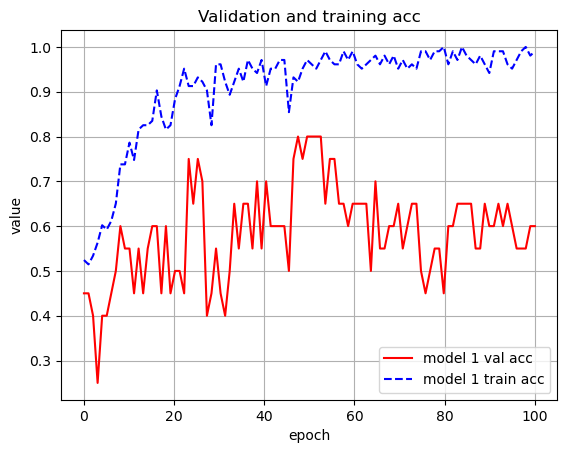

In [18]:
validation_accuracies = torch.Tensor([accuracies_val], device='cpu')
train_accuracies = torch.Tensor([accuracies_train], device='cpu')
colors = ['r', 'b', 'g']

for i in range(len(validation_accuracies)):
    xvalues = np.linspace(0, N_EPOCHS, len(validation_accuracies[i]))
    yvalues01 = validation_accuracies[i]
    yvalues02 = train_accuracies[i]
    name = "model %i "%(i+1)

    plt.plot(xvalues, yvalues01, label=name + "val acc", color='r')
    plt.plot(xvalues, yvalues02, label=name + "train acc", color='b', linestyle="dashed")

plt.title('Validation and training acc')
plt.xlabel('epoch')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()